The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of contourpy to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 7.9 

# Numerical Stability and Initialization
:label:`sec_numerical_stability`


Thus far, every model that we have implemented
required that we initialize its parameters
according to some pre-specified distribution.
Until now, we took the initialization scheme for granted,
glossing over the details of how these choices are made.
You might have even gotten the impression that these choices
are not especially important.
On the contrary, the choice of initialization scheme
plays a significant role in neural network learning,
and it can be crucial for maintaining numerical stability.
Moreover, these choices can be tied up in interesting ways
with the choice of the nonlinear activation function.
Which function we choose and how we initialize parameters
can determine how quickly our optimization algorithm converges.
Poor choices here can cause us to encounter
exploding or vanishing gradients while training.
In this section, we delve into these topics in greater detail
and discuss some useful heuristics
that you will find useful
throughout your career in deep learning.


In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

## Vanishing and Exploding Gradients

Consider a deep network with $L$ layers,
input $\mathbf{x}$ and output $\mathbf{o}$.
With each layer $l$ defined by a transformation $f_l$
parametrized by weights $\mathbf{W}^{(l)}$,
whose hidden layer output is $\mathbf{h}^{(l)}$ (let $\mathbf{h}^{(0)} = \mathbf{x}$),
our network can be expressed as:

$$\mathbf{h}^{(l)} = f_l (\mathbf{h}^{(l-1)}) \textrm{ and thus } \mathbf{o} = f_L \circ \cdots \circ f_1(\mathbf{x}).$$

If all the hidden layer output and the input are vectors,
we can write the gradient of $\mathbf{o}$ with respect to
any set of parameters $\mathbf{W}^{(l)}$ as follows:

$$\partial_{\mathbf{W}^{(l)}} \mathbf{o} = \underbrace{\partial_{\mathbf{h}^{(L-1)}} \mathbf{h}^{(L)}}_{ \mathbf{M}^{(L)} \stackrel{\textrm{def}}{=}} \cdots \underbrace{\partial_{\mathbf{h}^{(l)}} \mathbf{h}^{(l+1)}}_{ \mathbf{M}^{(l+1)} \stackrel{\textrm{def}}{=}} \underbrace{\partial_{\mathbf{W}^{(l)}} \mathbf{h}^{(l)}}_{ \mathbf{v}^{(l)} \stackrel{\textrm{def}}{=}}.$$

In other words, this gradient is
the product of $L-l$ matrices
$\mathbf{M}^{(L)} \cdots \mathbf{M}^{(l+1)}$
and the gradient vector $\mathbf{v}^{(l)}$.
Thus we are susceptible to the same
problems of numerical underflow that often crop up
when multiplying together too many probabilities.
When dealing with probabilities, a common trick is to
switch into log-space, i.e., shifting
pressure from the mantissa to the exponent
of the numerical representation.
Unfortunately, our problem above is more serious:
initially the matrices $\mathbf{M}^{(l)}$ may have a wide variety of eigenvalues.
They might be small or large, and
their product might be *very large* or *very small*.

The risks posed by unstable gradients
go beyond numerical representation.
Gradients of unpredictable magnitude
also threaten the stability of our optimization algorithms.
We may be facing parameter updates that are either
(i) excessively large, destroying our model
(the *exploding gradient* problem);
or (ii) excessively small
(the *vanishing gradient* problem),
rendering learning impossible as parameters
hardly move on each update.


### (**Vanishing Gradients**)

One frequent culprit causing the vanishing gradient problem
is the choice of the activation function $\sigma$
that is appended following each layer's linear operations.
Historically, the sigmoid function
$1/(1 + \exp(-x))$ (introduced in :numref:`sec_mlp`)
was popular because it resembles a thresholding function.
Since early artificial neural networks were inspired
by biological neural networks,
the idea of neurons that fire either *fully* or *not at all*
(like biological neurons) seemed appealing.
Let's take a closer look at the sigmoid
to see why it can cause vanishing gradients.


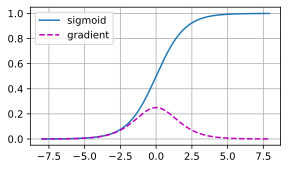

In [2]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

As you can see, (**the sigmoid's gradient vanishes
both when its inputs are large and when they are small**).
Moreover, when backpropagating through many layers,
unless we are in the Goldilocks zone, where
the inputs to many of the sigmoids are close to zero,
the gradients of the overall product may vanish.
When our network boasts many layers,
unless we are careful, the gradient
will likely be cut off at some layer.
Indeed, this problem used to plague deep network training.
Consequently, ReLUs, which are more stable
(but less neurally plausible),
have emerged as the default choice for practitioners.


### [**Exploding Gradients**]

The opposite problem, when gradients explode,
can be similarly vexing.
To illustrate this a bit better,
we draw 100 Gaussian random matrices
and multiply them with some initial matrix.
For the scale that we picked
(the choice of the variance $\sigma^2=1$),
the matrix product explodes.
When this happens because of the initialization
of a deep network, we have no chance of getting
a gradient descent optimizer to converge.


In [25]:
M = torch.normal(0, 1, size=(4, 4))
print('a single matrix \n',M)
for i in range(100):
    M = M @ torch.normal(0, 1, size=(4, 4))
print('after multiplying 100 matrices\n', M)

a single matrix 
 tensor([[ 0.4106, -0.8334, -0.4095, -0.2560],
        [-1.0887, -0.9338, -0.2916,  0.3924],
        [-1.2729,  0.0298, -1.6152,  0.2867],
        [-0.0411, -0.2799, -0.5590,  0.4118]])
after multiplying 100 matrices
 tensor([[-3.3335e+22,  4.1127e+22, -4.6573e+23,  5.4099e+23],
        [-1.3677e+23,  1.6873e+23, -1.9108e+24,  2.2196e+24],
        [-7.8084e+22,  9.6335e+22, -1.0909e+24,  1.2672e+24],
        [ 4.5732e+22, -5.6421e+22,  6.3893e+23, -7.4218e+23]])


### Breaking the Symmetry

Another problem in neural network design
is the symmetry inherent in their parametrization.
Assume that we have a simple MLP
with one hidden layer and two units.
In this case, we could permute the weights $\mathbf{W}^{(1)}$
of the first layer and likewise permute
the weights of the output layer
to obtain the same function.
There is nothing special differentiating
the first and second hidden units.
In other words, we have permutation symmetry
among the hidden units of each layer.

This is more than just a theoretical nuisance.
Consider the aforementioned one-hidden-layer MLP
with two hidden units.
For illustration,
suppose that the output layer transforms the two hidden units into only one output unit.
Imagine what would happen if we initialized
all the parameters of the hidden layer
as $\mathbf{W}^{(1)} = c$ for some constant $c$.
In this case, during forward propagation
either hidden unit takes the same inputs and parameters
producing the same activation
which is fed to the output unit.
During backpropagation,
differentiating the output unit with respect to parameters $\mathbf{W}^{(1)}$ gives a gradient all of whose elements take the same value.
Thus, after gradient-based iteration (e.g., minibatch stochastic gradient descent),
all the elements of $\mathbf{W}^{(1)}$ still take the same value.
Such iterations would
never *break the symmetry* on their own
and we might never be able to realize
the network's expressive power.
The hidden layer would behave
as if it had only a single unit.
Note that while minibatch stochastic gradient descent would not break this symmetry,
dropout regularization (to be introduced later) would!


## Parameter Initialization

One way of addressing---or at least mitigating---the
issues raised above is through careful initialization.
As we will see later,
additional care during optimization
and suitable regularization can further enhance stability.


### Default Initialization

In the previous sections, e.g., in :numref:`sec_linear_concise`,
we used a normal distribution
to initialize the values of our weights.
If we do not specify the initialization method, the framework will
use a default random initialization method, which often works well in practice
for moderate problem sizes.






### Xavier Initialization
:label:`subsec_xavier`

Let's look at the scale distribution of
an output $o_{i}$ for some fully connected layer
*without nonlinearities*.
With $n_\textrm{in}$ inputs $x_j$
and their associated weights $w_{ij}$ for this layer,
an output is given by

$$o_{i} = \sum_{j=1}^{n_\textrm{in}} w_{ij} x_j.$$

The weights $w_{ij}$ are all drawn
independently from the same distribution.
Furthermore, let's assume that this distribution
has zero mean and variance $\sigma^2$.
Note that this does not mean that the distribution has to be Gaussian,
just that the mean and variance need to exist.
For now, let's assume that the inputs to the layer $x_j$
also have zero mean and variance $\gamma^2$
and that they are independent of $w_{ij}$ and independent of each other.
In this case, we can compute the mean of $o_i$:

$$
\begin{aligned}
    E[o_i] & = \sum_{j=1}^{n_\textrm{in}} E[w_{ij} x_j] \\&= \sum_{j=1}^{n_\textrm{in}} E[w_{ij}] E[x_j] \\&= 0, \end{aligned}$$

and the variance:

$$
\begin{aligned}
    \textrm{Var}[o_i] & = E[o_i^2] - (E[o_i])^2 \\
        & = \sum_{j=1}^{n_\textrm{in}} E[w^2_{ij} x^2_j] - 0 \\
        & = \sum_{j=1}^{n_\textrm{in}} E[w^2_{ij}] E[x^2_j] \\
        & = n_\textrm{in} \sigma^2 \gamma^2.
\end{aligned}
$$

One way to keep the variance fixed
is to set $n_\textrm{in} \sigma^2 = 1$.
Now consider backpropagation.
There we face a similar problem,
albeit with gradients being propagated from the layers closer to the output.
Using the same reasoning as for forward propagation,
we see that the gradients' variance can blow up
unless $n_\textrm{out} \sigma^2 = 1$,
where $n_\textrm{out}$ is the number of outputs of this layer.
This leaves us in a dilemma:
we cannot possibly satisfy both conditions simultaneously.
Instead, we simply try to satisfy:

$$
\begin{aligned}
\frac{1}{2} (n_\textrm{in} + n_\textrm{out}) \sigma^2 = 1 \textrm{ or equivalently }
\sigma = \sqrt{\frac{2}{n_\textrm{in} + n_\textrm{out}}}.
\end{aligned}
$$

This is the reasoning underlying the now-standard
and practically beneficial *Xavier initialization*,
named after the first author of its creators :cite:`Glorot.Bengio.2010`.
Typically, the Xavier initialization
samples weights from a Gaussian distribution
with zero mean and variance
$\sigma^2 = \frac{2}{n_\textrm{in} + n_\textrm{out}}$.
We can also adapt this to
choose the variance when sampling weights
from a uniform distribution.
Note that the uniform distribution $U(-a, a)$ has variance $\frac{a^2}{3}$.
Plugging $\frac{a^2}{3}$ into our condition on $\sigma^2$
prompts us to initialize according to

$$U\left(-\sqrt{\frac{6}{n_\textrm{in} + n_\textrm{out}}}, \sqrt{\frac{6}{n_\textrm{in} + n_\textrm{out}}}\right).$$

Though the assumption for nonexistence of nonlinearities
in the above mathematical reasoning
can be easily violated in neural networks,
the Xavier initialization method
turns out to work well in practice.


### Beyond

The reasoning above barely scratches the surface
of modern approaches to parameter initialization.
A deep learning framework often implements over a dozen different heuristics.
Moreover, parameter initialization continues to be
a hot area of fundamental research in deep learning.
Among these are heuristics specialized for
tied (shared) parameters, super-resolution,
sequence models, and other situations.
For instance,
:citet:`Xiao.Bahri.Sohl-Dickstein.ea.2018` demonstrated the possibility of training
10,000-layer neural networks without architectural tricks
by using a carefully-designed initialization method.

If the topic interests you we suggest
a deep dive into this module's offerings,
reading the papers that proposed and analyzed each heuristic,
and then exploring the latest publications on the topic.
Perhaps you will stumble across or even invent
a clever idea and contribute an implementation to deep learning frameworks.


## Summary

Vanishing and exploding gradients are common issues in deep networks. Great care in parameter initialization is required to ensure that gradients and parameters remain well controlled.
Initialization heuristics are needed to ensure that the initial gradients are neither too large nor too small.
Random initialization is key to ensuring that symmetry is broken before optimization.
Xavier initialization suggests that, for each layer, variance of any output is not affected by the number of inputs, and variance of any gradient is not affected by the number of outputs.
ReLU activation functions mitigate the vanishing gradient problem. This can accelerate convergence.

## Exercises

1. Can you design other cases where a neural network might exhibit symmetry that needs breaking, besides the permutation symmetry in an MLP's layers?
1. Can we initialize all weight parameters in linear regression or in softmax regression to the same value?
1. Look up analytic bounds on the eigenvalues of the product of two matrices. What does this tell you about ensuring that gradients are well conditioned?
1. If we know that some terms diverge, can we fix this after the fact? Look at the paper on layerwise adaptive rate scaling  for inspiration :cite:`You.Gitman.Ginsburg.2017`.


[Discussions](https://discuss.d2l.ai/t/104)



5.4. Numerical Stability and Initialization


Vanishing and Exploding Gradients

Consider a deep neural network with L layers, with input x and output o.

We can see each layer l to be defined as a function f_l, parameterized by weights W_l, where the hidden layer output of said layer is h_l (and assume that h_0 = x).

So, each h_l = f_l(h_(l-1)), so then o = f_l∘...∘f_1(x)

Assuming that the output and input to each hidden layer is a vector, we can then write the gradient wrt to any W_l as:

∂o/∂W_l = ∂h_l/h_(L-1) ... ∂h_(l+1)/∂h_l ∂h_l/∂W_l

As such, the gradient of any W_l can be expressed as the product of L - l matrices M_L ... M_(l+1) and the gradient vector v_l

This means that the gradient faces the same issue of numerical underflow that often shows up when you multiply many probabilities. A common trick to deal with this is to switch into log space, as this shifts the pressure from the mantissa to the exponent of the numerical representation (because they become sums due to log(ab), and you need larger exponents to represent the same value). However this problem is more serious. As initially, M_l can have very small or very large values, their product can be very small or very large, which obviously means there is still an issue. As such, our parameter updates can be overly large (exploding gradients) causing divergence and destroying our model, or overly small (vanishing gradients) and causing updates to essentially have no effect.




Vanishing Gradients

The activation function frequently is the cause behind vanishing gradients. Sigmoid (1/(1+exp(-x)) was very popular, because it resembles a thresholding function, and since early neural networks were strongly inspired by biological ones, the idea of neurons being binary seemed appealing.

The issue is that sigmoids gradient becomes very small when values are very large or very small. This means that unless inputs to the sigmoid are very close to zero (which is where the gradient peaks at 0.25), there is a significant risk of gradients being cut off, just disappearing at a layer within your network. As such, ReLU became much preferred over the more biologically congruent sigmoid due to the fact that it is more stable.



Exploding Gradients

Exploding gradients are also a problem. To illustrate this, imagine 100 random gaussian matrices, with mean 0 and stdev 1.

Here is what a single matrix looks like:

[-0.8755, -1.2171,  1.3316,  0.1357]
[ 0.4399,  1.4073, -1.9131, -0.4608]
[-2.1420,  0.3643, -0.5267,  1.0277]
[-0.1734, -0.7549,  2.3024,  1.3085]


Here are 100 of them multiplied together:

[-2.9185e+23,  1.3915e+25, -1.1865e+25,  1.4354e+24]
[ 4.9142e+23, -2.3430e+25,  1.9979e+25, -2.4169e+24]
[ 2.6578e+23, -1.2672e+25,  1.0805e+25, -1.3072e+24]
[-5.2223e+23,  2.4899e+25, -2.1231e+25,  2.5684e+24]

From this, it is pretty easy to see how gradients can explode and completely destroy any change on convergence.



Breaking the Symmetry

Imagine a 3 layer mlp, with 2 hidden neurons and 1 output neuron. The issue is that the order of neurons does not matter. You can permute the order of weights W_1 of the hidden layer, and do the same for the output layer weights W_2, and your network will be identical in output. There is nothing differentiating the first and second hidden units, so we have permutation symmetry among the units of each hidden layer.

As such, if we initialize our weights of this hidden layer to the same constant, so W_1 = c.

Because each neuron takes in the same inputs, and multiplies them by the same weight, each neuron has the same activation value. As such, when you do to do backprop, they all recieve the exact same updates, so all of the new W_1 are still the same. This means that the network fundamentally hasn't changed, and has not learned anything. As such, the network cannot break symmetry, and this is identical in expressitivity to a network with a single hidden neuron. Minibatch stochastic gradient descent cannot break this, but dropout regularization (introduced later) can.



Parameter Initialization

One way of addressing the issues listed above is through careful initialization, and additional efforts during optimization and regularization can enhance stability.


Default Initialization

If no method is provided, the default is a gaussian distribution, which is good enough for moderate problem sizes.


Xavier Initialization

Lets look at the scale distribution for o_i, the output of a layer. with n_in inputs x_j, and weights w_ij for this layer, the output is given by:

o_i = sum_j=1,n_in(w_ij x_j)

The weights w_ij are all independelty drawn from a distribution with mean of 0 and variance sigma^2. It doesn't have to be gaussian, it just must have a mean and variance. Lets assume that the inputs to this layer, x_j, also have mean 0 and variance gamma^2

So, we can now compute the mean of o_i

E[o_i] = sum_j=1,n_in(E[(w_ij)(x_j)])

E[o_i] = sum_j=1,n_in(E[w_ij] E[x_j])

E[o_i] = 0

And variance:

Var[o_i] = E[o_i^2] - E[o_i]^2

Var[o_i] = sum_j=1,n_in(E[(w_ij^2)(x_j^2)]) - 0

Var[o_i] = sum_j=1,n_in(E[(w_ij^2)(x_j^2)])

Var[o_i] = (n_in)(sigma^2)(gamma^2)


We can keep the variance fixed by letting (n_in)(sigma^2) = 1

Using the same idea for forward prop, we need to keep (n_out)(sigma^2) = 1, or the gradients variance can explode.

However, we cannot satisfy both of these conditions at once. So our best option is then to keep 0.5(n_in + n_out)(sigma^2) = 1

Equivalently, we then get sigma = sqrt(2/(n_in + n_out))

This is the reasoning behind xavier initialization, where we sample weights from a gaussian distribution with mean 0 and variance = 2/(n_in + n_out)


This also works for sampling weights from a uniform distribution, U(-a, a), where the variance is (a^2)/3.

Plugging into the equation above, we find that we should initialize from U(-sqrt(6/(n_in + n_out)), sqrt(6/(n_in + n_out)))

So, xavier initialization works by inverting input count and variance to have the summed variance to be the same per layer, doing so across forward and backward passes by averaging their input count, to prevent gradients from vanishing or exploding.

While we violate the condition of no nonlinearities in the reasoning above, xavier initialization still works well in practice.



Beyond

This only covers a tiny segment of approaches to parameter initialization in deep learning. Modern deep learning can often use over a dozen methods. Among these are heuristics specialized for tied (shared) parameters, super-resolution, sequence models, and other situations. For instance, Xiao et al. (2018) demonstrated the possibility of training 10,000-layer neural networks without architectural tricks by using a carefully-designed initialization method.